# <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Описание</div>

Некая компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Необходимо достичь значения метрики *RMSE* на тестовой выборке не больше 48.

Для этого нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Содержание</div>

****

<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предварительный-анализ" data-toc-modified-id="Предварительный-анализ-1.4"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предварительный анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

****

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Подготовка</div>

### Импорт библиотек

In [127]:
# Импорты из стандартной библиотеки Python
import time
import warnings

# Импорты из сторонних библиотек
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from plotly.subplots import make_subplots
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from statsmodels.tsa.seasonal import seasonal_decompose

# Настройки
warnings.filterwarnings("ignore")

# Константы заглавными буквами
RANDOM_STATE = 1504

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Загрузка данных</div>

In [128]:
# используем конструкцию try-except для обработки ошибок при чтении файла
try:
    # читаем csv-файл и задаем первый столбец как индекс
    orders = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
except FileNotFoundError:
    # если файл не найден, выводим сообщение об ошибке
    print("Файл не найден")

In [129]:
def check_df(df):
    print("СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ")
    print("*" * 30)

    print("===ОБЩАЯ ИНФОРМАЦИЯ===")
    display(df.info())
    print("*" * 30)

    print("===СЛУЧАЙНЫЕ 5 СТРОК ДАТАФРЕЙМА===")
    display(df.sample(n=5))
    print("*" * 30)

    print("===СТАТИСТИКА===")
    display(df.describe())
    print("*" * 30)

    print("===ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ===")
    print(df.isna().sum())
    print("*" * 30)

    print("===ВРЕМЕННОЙ ИНТЕРВАЛ===")
    print(f"Начало интервала: {df.index.min()}")
    print(f"Конец интервала: {df.index.max()}")
    print("*" * 30)

    print("===ГРАФИЧЕСКОЕ ПРЕДСТАВЛЕНИЕ===")
    # Создание графика с помощью функции px.line()
    fig = px.line(df, x=df.index, y="num_orders")

    # Устанавливаем заголовки осей, ширину и шаблон графика
    fig.update_layout(
        xaxis_title="dates", yaxis_title="num_orders", width=900, template="plotly_dark"
    )

    # Отображаем график
    fig.show("png")

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************
===ОБЩАЯ ИНФОРМАЦИЯ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

******************************
===СЛУЧАЙНЫЕ 5 СТРОК ДАТАФРЕЙМА===


,num_orders
datetime,
2018-04-25 01:10:00,3
2018-06-29 01:20:00,9
2018-04-21 06:10:00,7
2018-08-07 18:30:00,15
2018-05-31 15:30:00,10


******************************
===СТАТИСТИКА===


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


******************************
===ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ===
num_orders    0
dtype: int64
******************************
===ВРЕМЕННОЙ ИНТЕРВАЛ===
Начало интервала: 2018-03-01 00:00:00
Конец интервала: 2018-08-31 23:50:00
******************************
===ГРАФИЧЕСКОЕ ПРЕДСТАВЛЕНИЕ===


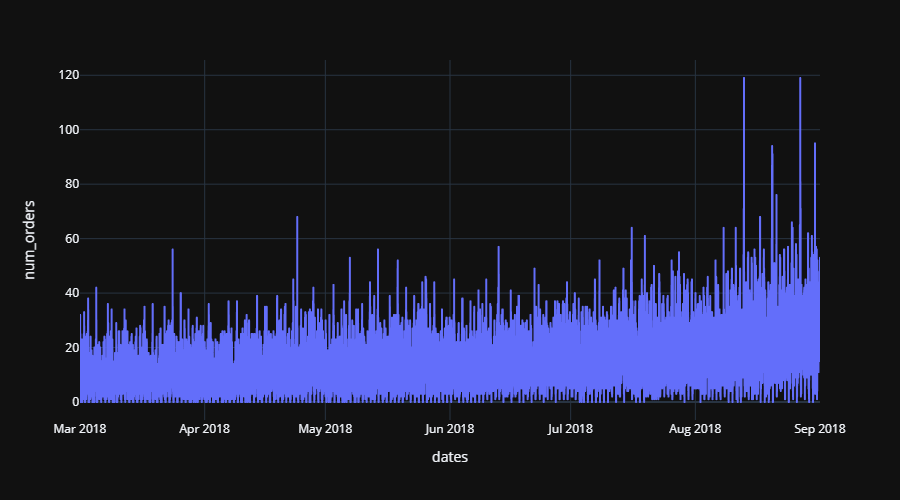

In [130]:
check_df(orders)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Предварительный анализ</div>

Итак, что мы имеем:
1. Набор данных, состоящий из 26 496 записей, с одним признаком `num_orders` и индексом, содержащим временной ряд;
1. `num_orders` имеет тип данных int64, который в данном случае явно избыточен.
1. Данные взяты за период с 01.03.2018 по 31.08.2018, с 00:00 до 23:50 соответственно.
1. В данных отсутствуют пропуски;
1. Осуществлять проверку на наличие дубликатов бессмыссленно, т.к. кол-во заказов может повторятся и это нормально.


В целом данные хорошие, осталось только сделать пару штрихов:

1. Ресемплировать данные по одному часу
1. Преобразовать тип данных признака `num_orders`, применив к нему метод downcast;

In [131]:
# Ресемплируем данные по одному часу
orders = orders.resample("1H").sum()

In [132]:
# Преобразовываем тип данных num_orders
orders.num_orders = pd.to_numeric(orders.num_orders, downcast="integer")
orders.num_orders.dtype

dtype('int16')

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************
===ОБЩАЯ ИНФОРМАЦИЯ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 43.1 KB


None

******************************
===СЛУЧАЙНЫЕ 5 СТРОК ДАТАФРЕЙМА===


,num_orders
datetime,
2018-03-14 17:00:00,57
2018-08-17 01:00:00,173
2018-05-20 00:00:00,112
2018-05-13 20:00:00,94
2018-07-07 22:00:00,91


******************************
===СТАТИСТИКА===


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


******************************
===ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ===
num_orders    0
dtype: int64
******************************
===ВРЕМЕННОЙ ИНТЕРВАЛ===
Начало интервала: 2018-03-01 00:00:00
Конец интервала: 2018-08-31 23:00:00
******************************
===ГРАФИЧЕСКОЕ ПРЕДСТАВЛЕНИЕ===


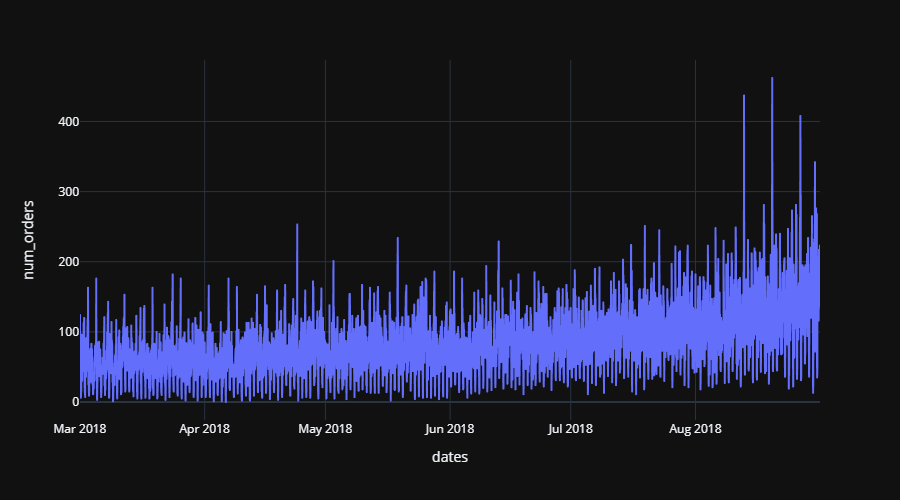

In [133]:
check_df(orders)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Вывод</div>

Данные были загруженны и проанализированны. В результате анализа было произведено ресемплированние данных и понижена разрядность числового типа данных признака `num_orders` для уменьшения ресурсозатрат при обучении модели.

Данные готовы к дальнейшему исследованию.

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Анализ</div>

Выполним декомпозицию данных, применив функцию `seasonal_decompose()`, чтобы лучше проанализировать данные:

In [134]:
decomposed_orders = seasonal_decompose(orders)
decomposed_orders.trend

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: H, Name: trend, Length: 4416, dtype: float64

Оценим общий тренд:

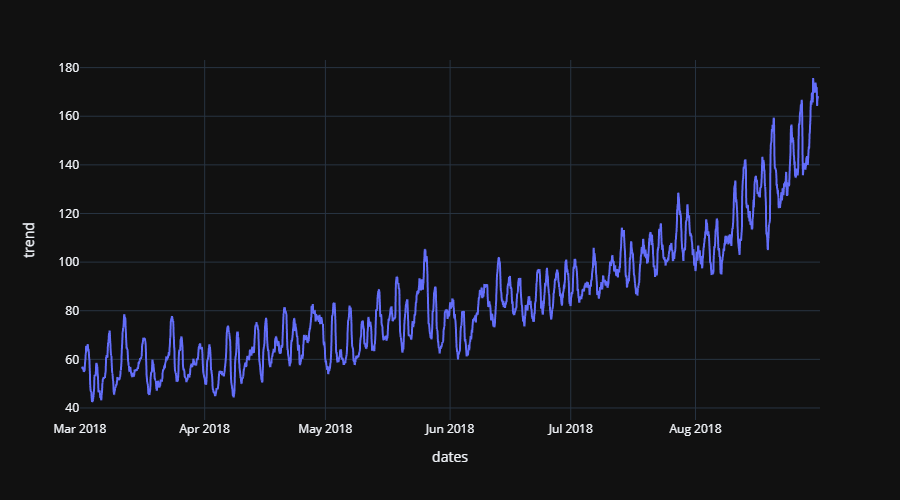

In [135]:
# Создаем график с помощью функции px.line()
fig = px.line(decomposed_orders.trend, x=decomposed_orders.trend.index, y="trend")

# Устанавливаем заголовки осей, ширину и шаблон графика
fig.update_layout(
    xaxis_title="dates", yaxis_title="trend", width=900, template="plotly_dark"
)

# Отображаем график
fig.show("png")

График растет. Количество вызовов такси в аэропорт летом вырастает. Можно предположить, что это аэропорт какого-то курортного города.

Посмотрим поближе крайние 2 недели:

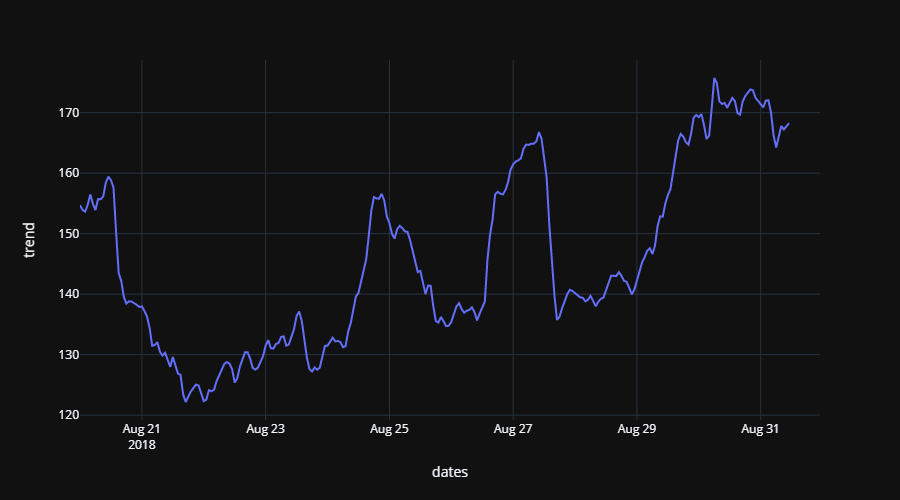

In [136]:
# Получаем данные за последние две недели
trend_last_2w = decomposed_orders.trend.last("2W")

# Создаем график с помощью функции px.line()
fig = px.line(trend_last_2w, x=trend_last_2w.index, y="trend")

# Устанавливаем заголовки осей, ширину и шаблон графика
fig.update_layout(
    xaxis_title="dates", yaxis_title="trend", width=900, template="plotly_dark"
)

# Отображаем график
fig.show("png")

Видим, что количество заказов не равномерно в течении недели. В начале недели наблюдается спад, который переходит в к концу недели.

Теперь оценим сезонную составляющую:

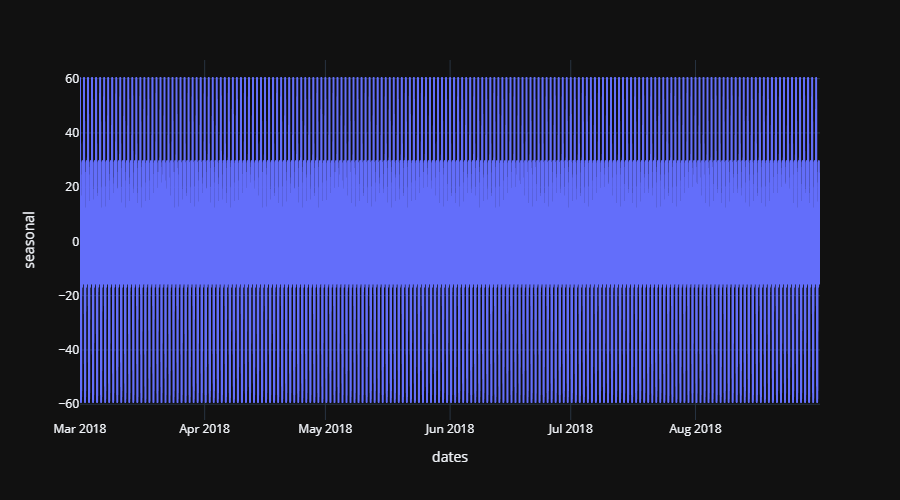

In [137]:
# Получаем данные за последние две недели
seasonal = decomposed_orders.seasonal

# Создаем график с помощью функции px.line()
fig = px.line(seasonal, x=seasonal.index, y="seasonal")

# Устанавливаем заголовки осей, ширину и шаблон графика
fig.update_layout(
    xaxis_title="dates", yaxis_title="seasonal", width=900, template="plotly_dark"
)

# Отображаем график
fig.show("png")

Аж зарябило в глазах, попробуем взять только последнюю неделю:

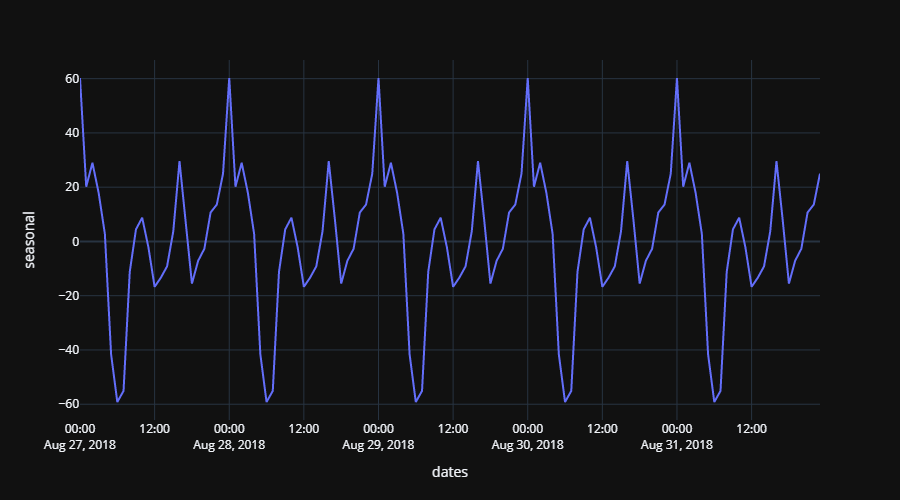

In [138]:
# Получаем сезонные данные данные за последнюю неделю
seasonal_last_week = decomposed_orders.seasonal.last("1W")

# Создаем график с помощью функции px.line()
fig = px.line(seasonal_last_week, x=seasonal_last_week.index, y="seasonal")

# Устанавливаем заголовки осей, ширину и шаблон графика
fig.update_layout(
    xaxis_title="dates", yaxis_title="seasonal", width=900, template="plotly_dark"
)

# Отображаем график
fig.show("png")

Мы видим, что пик нагрузки приходится на полночь, но затем количество заказов пададает вплоть до 06:00, после чего снова начинает расти. Очевидно, что это связано с ночными рейсами. 

Посмотрим на остатки декомпозиции:

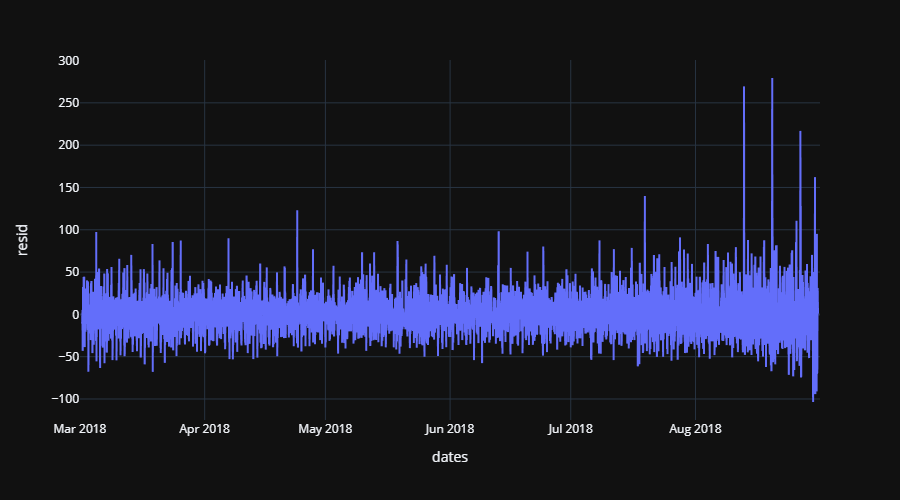

In [139]:
# Получаем сезонные данные данные за последнюю неделю
resid = decomposed_orders.resid

# Создаем график с помощью функции px.line()
fig = px.line(resid, x=resid.index, y="resid")

# Устанавливаем заголовки осей, ширину и шаблон графика
fig.update_layout(
    xaxis_title="dates", yaxis_title="resid", width=900, template="plotly_dark"
)

# Отображаем график
fig.show("png")

Дисперсия увеличивается со временем, наиболее хорошо это заметно во второй половине августа

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Вывод</div>

Проведя анализ данных определим признаки, которые нам понадобятся для обучения наших моделей:

1. `hour` - ночью такси вызывают активнее, значит время вызова имеет значение
1. `day` - поскольку, в середине недели заказов меньше, чем в выходные.
1. `dayofweek` - аналогично предыдущему - интенсивность заказов в течение недели скачет.
1. `month` - тренд растет от месяца к месяцу, этот признак нам понадобится

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Обучение</div>

Для обучения выберем 4 модели:
1. Ridge
2. DecisionTree
3. CatBoostRegressor
4. LightGBMRegressor

Напишем функцию для создания необходимых признаков:

In [140]:
def make_features(df, max_lag, rolling_mean_size):
    # создаем копию исходного датафрейма для изменений
    df_with_features = df.copy()

    # календарные фичи
    df_with_features["month"] = df.index.month
    df_with_features["day"] = df.index.day
    df_with_features["dayofweek"] = df.index.dayofweek
    df_with_features["hour"] = df.index.hour

    # "отстающие" фичи
    for lag in range(1, max_lag + 1):
        df_with_features[f"lag_{lag}"] = df_with_features.num_orders.shift(lag)

    # "скользящее среднее"
    df_with_features["rolling_sum"] = (
        df_with_features.num_orders.shift().rolling(rolling_mean_size).mean()
    )

    return df_with_features

Применим нашу функцию и посмотрим на результат

In [141]:
new_orders = make_features(orders, 24, 4)
new_orders.head(5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


Подготовим выборки для обучения моделей:

In [142]:
train, test = train_test_split(new_orders, shuffle=False, test_size=0.1)
train = train.dropna()

In [143]:
X_train = train.drop("num_orders", axis=1)
y_train = train.num_orders
X_test = test.drop("num_orders", axis=1)
y_test = test.num_orders

In [144]:
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 3950
Размер тестовой выборки: 442


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Обучение моделей</div>

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Ridge</div>

In [145]:
%%time
# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.1, 0.01),
}

# ищем лучшие гиперпараметры
tscv = TimeSeriesSplit(n_splits=5)
gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge,
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

# обучаем модель
gs_ridge.fit(X_train, y_train)

gs_ridge_best_params = gs_ridge.best_params_
gs_ridge_best_score = abs(gs_ridge.best_score_)
gs_ridge_fit_time = gs_ridge.cv_results_['mean_fit_time'][gs_ridge.best_index_]
gs_ridge_predict_time = gs_ridge.cv_results_['mean_score_time'][gs_ridge.best_index_]

print(f"best_params: {gs_ridge_best_params}")
print('------------------------------')
print(f"best_score: {gs_ridge_best_score}")
print(f"gs_ridge_fit_time: {gs_ridge_fit_time}")
print(f"gs_ridge_predict_time: {gs_ridge_predict_time}")


best_params: {'alpha': 0.01}
------------------------------
best_score: 26.94133895954718
gs_ridge_fit_time: 0.00559849739074707
gs_ridge_predict_time: 0.0020015716552734377
CPU times: total: 219 ms
Wall time: 4.02 s


#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">DecisionTreeRegressor</div>

In [146]:
%%time

model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_grid_dt = {
    "max_depth": range(2, 15),
    "min_samples_split": (2, 3, 4),
    "min_samples_leaf": (1, 2, 3, 4),
}
tscv = TimeSeriesSplit(n_splits=5)
gs_dt = RandomizedSearchCV(
    model_dt,
    param_distributions=param_grid_dt,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

gs_dt.fit(X_train, y_train)

gs_dt_best_params = gs_dt.best_params_
gs_dt_best_score = abs(gs_dt.best_score_)
gs_dt_fit_time = gs_dt.cv_results_['mean_fit_time'][gs_dt.best_index_]
gs_dt_predict_time = gs_dt.cv_results_['mean_score_time'][gs_dt.best_index_]

print(f"best_params: {gs_dt_best_params}")
print('------------------------------')
print(f"best_score: {gs_dt_best_score}")
print(f"gs_dt_fit_time: {gs_dt_fit_time}")
print(f"gs_dt_predict_time: {gs_dt_predict_time}")

best_params: {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 5}
------------------------------
best_score: 30.190032608214104
gs_dt_fit_time: 0.023200082778930663
gs_dt_predict_time: 0.0030002593994140625
CPU times: total: 125 ms
Wall time: 325 ms


#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">CatBoostRegressor</div>

In [147]:
%%time

# Создаем модель CatBoostRegressor с фиксированным random_state
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)

# Задаем сетку параметров для перебора
param_grid_cbr = {
    "max_depth": [6, 10],  # глубина дерева
    "n_estimators": [50, 200],
    "learning_rate": [0.01, 0.1],  # скорость обучения
}

# Задаем кросс-валидацию
tscv = TimeSeriesSplit(n_splits=5)

# Создаем объект RandomizedSearchCV для подбора оптимальных гиперпараметров
gs_cbr = RandomizedSearchCV(
    model_cbr,
    param_distributions=param_grid_cbr,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

# Обучаем модель на тренировочных данных
gs_cbr.fit(X_train, y_train)

# Получаем лучшие гиперпараметры и метрику на кросс-валидации
gs_cbr_best_params = gs_cbr.best_params_
gs_cbr_best_score = abs(gs_cbr.best_score_)

# Получаем время обучения и предсказания модели
gs_cbr_fit_time = gs_cbr.cv_results_["mean_fit_time"][gs_cbr.best_index_]
gs_cbr_predict_time = gs_cbr.cv_results_["mean_score_time"][gs_cbr.best_index_]

# Выводим результаты
print(f"best_params: {gs_cbr_best_params}")
print("------------------------------")
print(f"best_score: {gs_cbr_best_score}")
print(f"gs_cbr_fit_time: {gs_cbr_fit_time}")  # время обучения модели
print(f"gs_cbr_predict_time: {gs_cbr_predict_time}")  # время предсказания модели

0:	learn: 36.9397873	total: 2.53ms	remaining: 503ms
1:	learn: 35.1982065	total: 4.74ms	remaining: 470ms
2:	learn: 33.7613167	total: 6.84ms	remaining: 449ms
3:	learn: 32.5433230	total: 8.92ms	remaining: 437ms
4:	learn: 31.4547490	total: 11ms	remaining: 429ms
5:	learn: 30.4452008	total: 13.1ms	remaining: 425ms
6:	learn: 29.6426128	total: 15.3ms	remaining: 422ms
7:	learn: 28.9758602	total: 17.6ms	remaining: 421ms
8:	learn: 28.2687732	total: 19.7ms	remaining: 418ms
9:	learn: 27.6751713	total: 21.7ms	remaining: 413ms
10:	learn: 27.2379142	total: 23.8ms	remaining: 409ms
11:	learn: 26.8222486	total: 25.8ms	remaining: 405ms
12:	learn: 26.4570972	total: 27.9ms	remaining: 401ms
13:	learn: 25.9663588	total: 30.7ms	remaining: 408ms
14:	learn: 25.6727938	total: 32.9ms	remaining: 405ms
15:	learn: 25.3793288	total: 34.8ms	remaining: 401ms
16:	learn: 25.1145934	total: 36.9ms	remaining: 397ms
17:	learn: 24.8972644	total: 38.9ms	remaining: 393ms
18:	learn: 24.6839688	total: 40.9ms	remaining: 390ms
19:	l

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">LightGBM</div>

In [148]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

param_grid_lgbm = {
    "n_estimators": range(38, 42, 1),
    "learning_rate": [0.05, 0.1, 0.15],
    "max_depth": [3, 5, 7],
    "min_child_samples": [10, 20, 30],
    "num_leaves": [25, 50, 75]
}

tscv = TimeSeriesSplit(n_splits=5)

gs_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_distributions=param_grid_lgbm,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_iter=10,
    random_state=RANDOM_STATE,
)

gs_lgbm.fit(X_train, y_train)

gs_lgbm_best_params = gs_lgbm.best_params_
gs_lgbm_best_score = abs(gs_lgbm.best_score_)
gs_lgbm_fit_time = gs_lgbm.cv_results_['mean_fit_time'][gs_lgbm.best_index_]
gs_lgbm_predict_time = gs_lgbm.cv_results_['mean_score_time'][gs_lgbm.best_index_]

print(f"best_params: {gs_lgbm_best_params}")
print('------------------------------')
print(f"best_score: {gs_lgbm_best_score}")
print(f"gs_lgbm_fit_time: {gs_lgbm_fit_time}")
print(f"gs_lgbm_predict_time: {gs_lgbm_predict_time}")


best_params: {'num_leaves': 50, 'n_estimators': 38, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.15}
------------------------------
best_score: 24.834485361691215
gs_lgbm_fit_time: 0.022601318359375
gs_lgbm_predict_time: 0.0023987293243408203
CPU times: total: 12.6 s
Wall time: 1.17 s


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Вывод</div>

In [149]:
result_grid = pd.DataFrame(
    index=["RMSE", "fit time", "predict time"],
    columns=["Ridge", "DecisionTreeRegressor", "CatBoostRegressor", "LightGBM"],
)

result_grid.loc["RMSE"] = [
    gs_ridge_best_score,
    gs_dt_best_score,
    gs_cbr_best_score,
    gs_lgbm_best_score,
]
result_grid.loc["fit time"] = [
    gs_ridge_fit_time,
    gs_dt_fit_time,
    gs_cbr_fit_time,
    gs_lgbm_fit_time,
]
result_grid.loc["predict time"] = [
    gs_ridge_predict_time,
    gs_dt_predict_time,
    gs_cbr_predict_time,
    gs_lgbm_predict_time,
]

# Find the minimum value in each row
min_per_row = result_grid.min(axis=1)


# Apply a style that highlights the minimum value in each row
def highlight_min(s):
    is_min = s == s.min()
    return ["background-color: green" if v else "" for v in is_min]


styled_result_grid = result_grid.style.apply(highlight_min, axis=1)
styled_result_grid

,Ridge,DecisionTreeRegressor,CatBoostRegressor,LightGBM
RMSE,26.941339,30.190033,24.529745,24.834485
fit time,0.005598,0.023200,5.815395,0.022601
predict time,0.002002,0.003000,0.008000,0.002399


Мы подготовили выборки и обучили наши модели. Лучшее значение метрики RMSE показала модель CatBoostRegressor. LightGBM отстала от лидера совсем на чуть-чуть, но показала при этом гораздо более высокую скорость предсказания. Поэтому, если бы в задании требовалась еще и быстрота работы, то LightGBM определенно победила бы. При этом стоит отметить, что все выбранные  и обученные модели попали к целевой диапазон метрики, необходимый по заданию текущего исследования.

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Тестирование</div>

In [150]:
lgbm_prediction = gs_cbr.predict(X_test)
lgbm_rmse_test = mean_squared_error(y_test, lgbm_prediction, squared=False)
lgbm_rmse_test

41.428717368569906

In [151]:
result = pd.DataFrame({"Target": y_test, "Prediction": lgbm_prediction})

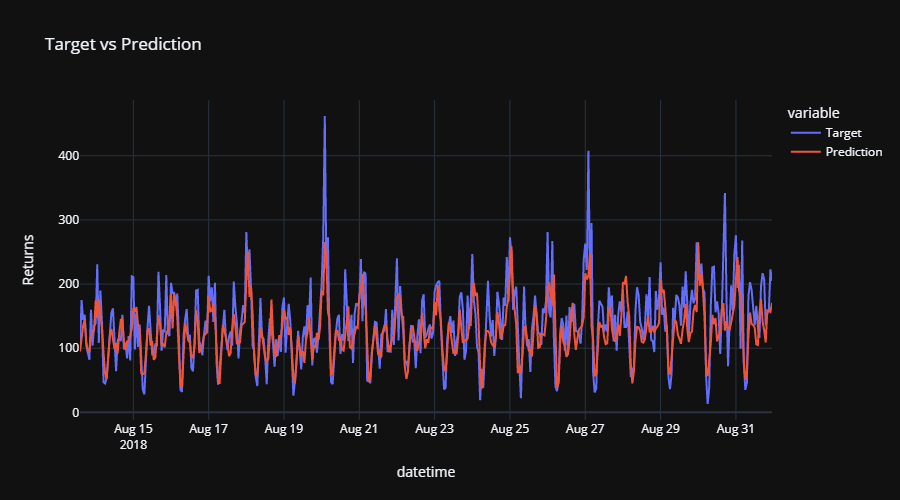

In [152]:
fig = px.line(
    result,
    x=result.index,
    y=["Target", "Prediction"],
    title="Target vs Prediction",
    labels={"index": "Dates", "value": "Returns"},
)
fig.update_layout(template="plotly_dark", width=900)
fig.show("png")

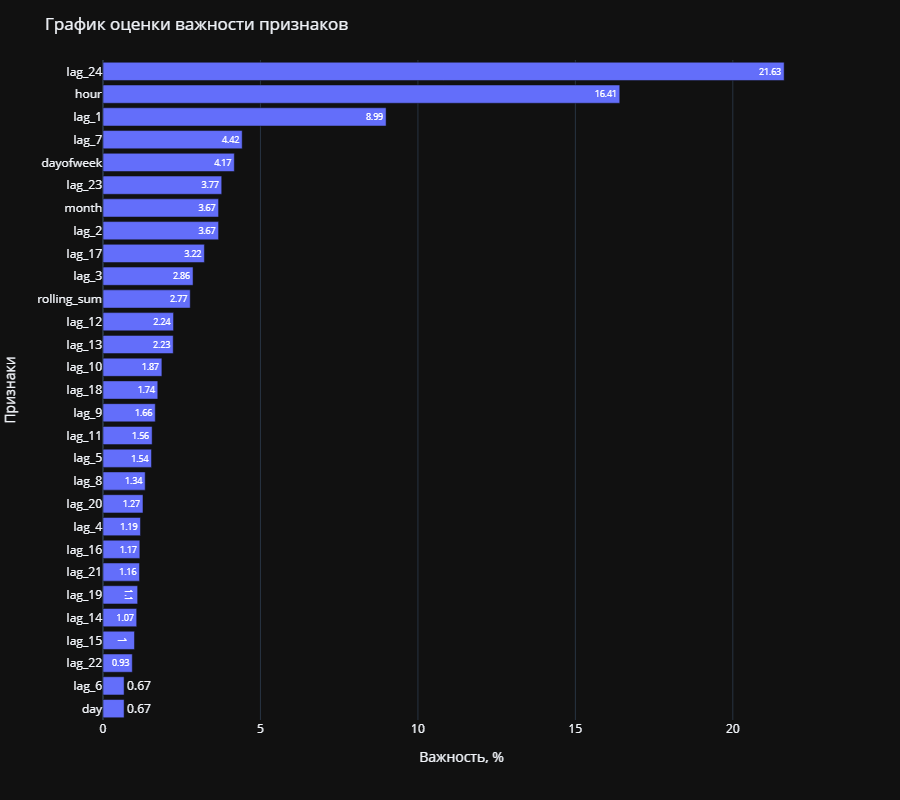

In [153]:
# создаем график
importance_percent = np.round(
    gs_cbr.best_estimator_.feature_importances_
    / np.sum(gs_cbr.best_estimator_.feature_importances_)
    * 100,
    2,
)
fig = px.bar(
    pd.Series(importance_percent, index=X_test.columns).sort_values(ascending=True),
    orientation="h",
    text_auto=True,
)

# настраиваем параметры графика
fig.update_layout(
    title="График оценки важности признаков",
    xaxis_title="Важность, %",
    yaxis_title="Признаки",
    showlegend=False,
    template="plotly_dark",
    height=800,
    width=900,
)

# выводим график
fig.show("png")

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Вывод</div>

В ходе настоящего исследования мы загрузили и проанализировали данные. Разбили данные на выборки для обучения модели. Определили 4 типа моделей - Ridge, DecisionTree, CatBoostRegressor, LGBMRegressor, для которых нашли лучшие гиперпараметры, время обучения и предсказания. В завершении проанализировали модели, опираясь на значения метрики RMSE, в результате чего можно сделать вывод о том, что наиболее подходящей моделью (из выбранных нами для исследования) для прогнозирования количества заказов такси на следующий час явялется модель **CatBoostRegressor**. По качеству предсказаний ближе всего к ней была LGBM-модель. Линейная же и "деревянная" же модели, отстали по этому параметру на несколько пунктов.